<a href="https://colab.research.google.com/github/mrodrigues05/Valor-em-risco-VaR/blob/main/VaR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Value at Risk (VaR) é uma forma de medir o risco de um investimento, como uma carteira de ações. Em poucas palavras, o VaR estima a perda máxima que você pode esperar de um investimento em um determinado período e com uma certa probabilidade.

Pense nisso como responder à pergunta: "Qual é o máximo que posso perder com meu investimento em um dia com 95% de certeza?" O resultado do cálculo do VaR te dá o valor em dinheiro dessa possível perda.

Tomemos os preços de fechamento das ações do Banco do Brasil
(BBAS3) de 2015 a 2019

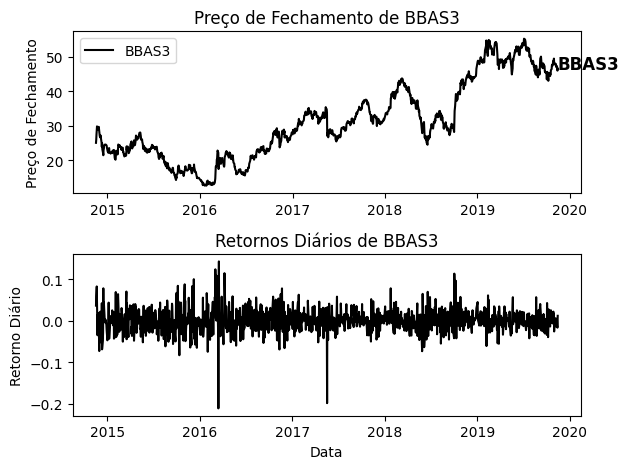


************ desvio padrão do ativo *********
0.02812265293110769


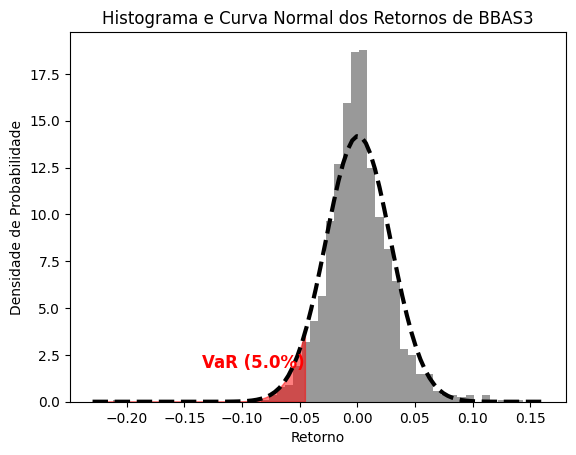


*+ VaR do ativo **********++
dias na posição futura -  1
VaR (5.0%) - retorno: -0.0454
VaR Monetário para 1 dia(s): R$ -2.11


In [4]:
import pandas as pd
import matplotlib.pyplot as plt # Corrigido 'fig' para 'plt'
import numpy as np
from scipy.stats import norm
import math

# Carregar dados
# Certifique-se de que o arquivo 'BBrasil.xlsx' está no diretório correto ou forneça o caminho completo.
try:
    df = pd.read_excel('BBrasil.xlsx', sheet_name='Planilha1')
except FileNotFoundError:
    print("Erro: O arquivo 'BBrasil.xlsx' não foi encontrado. Certifique-se de que ele está presente ou forneça o caminho correto.")
    # Você pode adicionar um sys.exit() aqui se quiser parar a execução em caso de erro.
    # import sys
    # sys.exit()
    # Ou carregar um DataFrame de exemplo para demonstração
    # data = {'Date': pd.to_datetime(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05']),
    #         'BBAS3': [100, 102, 101, 103, 105]}
    # df = pd.DataFrame(data)


# Lista de ativos
asset_list = ['BBAS3'] # Corrigido 'list' para 'asset_list'

if 'df' in locals() and not df.empty: # Verifica se o DataFrame foi carregado com sucesso
    # Plotar preços de fechamento
    plt.figure()
    ax1 = plt.subplot(211)
    ax1.plot(df['Date'], df[asset_list], '-k', alpha=1) # Corrigido 'df.Date' para 'df['Date']' e 'list' para 'asset_list'
    ax1.legend(asset_list)
    ax1.set_ylabel('Preço de Fechamento') # Adicionado rótulo do eixo y
    ax1.set_title('Preço de Fechamento de BBAS3') # Adicionado título

    # Adicionar rótulo de texto no final da linha
    for i in range(len(asset_list)):
        # Corrigido o acesso ao último elemento e o nome da variável
        ax1.text(x=df['Date'].iloc[-1], y=df[asset_list[i]].iloc[-1],
                 s=asset_list[i], fontsize=12, color='k', weight='bold')

    # Calcular retornos
    # exclui a coluna de datas para o cálculo do retorno
    prices = df.drop(['Date'], axis=1)
    # ************* retornos dos preços **************+
    returns = prices / prices.shift(1) - 1

    # retorno médio dos ativos por colunas
    # Corrigido o acesso ao valor médio e desvio padrão
    mean_return = returns.mean().values[0] # Acessa o valor do retorno médio
    # desvio padrão
    std_dev = returns.std().values[0] # Acessa o valor do desvio padrão

    # Plotar retornos diários
    ax2 = plt.subplot(212) # Corrigido o nome da variável do subplot
    ax2.plot(df['Date'][1:], returns.dropna(), '-k', alpha=1) # Plotar retornos a partir da segunda data
    ax2.set_xlabel('Data') # Adicionado rótulo do eixo x
    ax2.set_ylabel('Retorno Diário') # Adicionado rótulo do eixo y
    ax2.set_title('Retornos Diários de BBAS3') # Adicionado título

    plt.tight_layout() # Ajusta o layout para evitar sobreposição
    plt.show() # Exibe os gráficos

    print('\n************ desvio padrão do ativo *********')
    print(std_dev)

    # Histograma e curva normal do ativo
    plt.figure() # Cria uma nova figura para o histograma
    ax3 = plt.subplot(111) # Corrigido o nome da variável do subplot
    # Corrigido 'normed' para 'density' e passado os dados corretamente
    ax3.hist(returns.dropna(), bins=50, density=True, color='black', alpha=0.4) # Aumentado bins para melhor visualização

    # Corrigido o cálculo e a plotagem da curva normal
    xmin, xmax = ax3.get_xlim() # Obtém os limites do eixo x do histograma
    eixox = np.linspace(xmin, xmax, 100)
    eixoy = norm.pdf(eixox, mean_return, std_dev)
    ax3.plot(eixox, eixoy, '--k', linewidth=3)
    ax3.set_xlabel('Retorno')
    ax3.set_ylabel('Densidade de Probabilidade')
    ax3.set_title('Histograma e Curva Normal dos Retornos de BBAS3')

    # Calcular VaR
    confidence_level = 0.05 # 5% de risco (cauda esquerda)
    z = norm.ppf(confidence_level) # Z-score para o nível de confiança (cauda esquerda)

    # VaR: perda máxima esperada no nível de confiança
    VaR = mean_return + z * std_dev # VaR como um retorno negativo

    # Plotar VaR na curva normal
    ix = np.linspace(xmin, VaR, 100)
    iy = norm.pdf(ix, mean_return, std_dev)
    ax3.fill_between(ix, iy, color='red', alpha=0.5) # Preenche a área de risco em vermelho

    # Adicionar texto para o VaR
    ax3.text(VaR, norm.pdf(VaR, mean_return, std_dev) * 0.5,
             f'VaR ({confidence_level*100}%)', fontsize=12, color='red', weight='bold', ha='right') # Posição ajustada do texto

    plt.show() # Exibe o gráfico do histograma e VaR

    # *******************+ VOR Monetário (R$ ) +++++
    dias = 1 # dias que deseja manter o ativo no futuro

    # Certifica-se de que 'prices' não está vazio
    if not prices.empty:
        # VaR Monetário = VaR (como retorno) * Preço Atual * sqrt(dias)
        VaR_Mon = VaR * prices.iloc[-1].values[0] * math.sqrt(dias) # Acessa o último preço

        print('\n*+ VaR do ativo **********++')
        print('dias na posição futura - ', dias)
        print(f'VaR ({confidence_level*100}%) - retorno: {VaR:.4f}') # Exibe o VaR como retorno
        print(f'VaR Monetário para {dias} dia(s): R$ {VaR_Mon:.2f}')

    else:
        print("\nNão foi possível calcular o VaR Monetário: DataFrame 'prices' está vazio.")